In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage.segmentation import mark_boundaries
import itertools
import random
import time
import pickle

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [22]:
from coral_mapper_functions import score_map

In [5]:
from coral_mapper import coral_map

In [6]:
img_rugo_zones = np.load('../v2/data/pleiades_map_types_10m.npy')

In [7]:
pleiades_img = np.load('../v2/data/pleiades_ortho_10m.npy')

In [8]:
img_blue = (pleiades_img[1]-np.mean(pleiades_img[1]))/np.std(pleiades_img[1])
img_green = (pleiades_img[2]-np.mean(pleiades_img[2]))/np.std(pleiades_img[2])
img_red = (pleiades_img[3]-np.mean(pleiades_img[3]))/np.std(pleiades_img[3])
img_nir = (pleiades_img[0]-np.mean(pleiades_img[0]))/np.std(pleiades_img[0])

In [9]:
img = np.dstack((pleiades_img[3]/6000,
                pleiades_img[2]/6000,
                pleiades_img[1]/6000))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


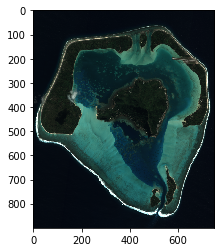

In [10]:
plt.imshow(img, interpolation='None')
plt.show()

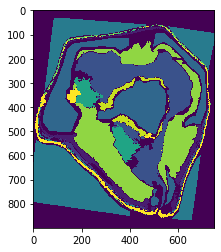

In [11]:
plt.imshow(img_rugo_zones, interpolation='None')
plt.show()

# Training the classifier

In [29]:
map_test = coral_map([img_blue,img_green,img_red,img_nir], map_img=img_rugo_zones, size_img=5)

In [30]:
classified_pixels = np.where(img_rugo_zones>0)

In [16]:
len(classified_pixels[0][:len(classified_pixels[0])//5])

88613

In [17]:
random.seed(0)
#size_subset = len(classified_pixels[0])//2
size_subset = 212695
index_combination = list(np.array(classified_pixels).T)
random_train_test = random.sample(index_combination,size_subset)
training_set_indexes_pb = random_train_test[:size_subset//5]
testing_set_indexes_pb = random_train_test[size_subset//5:]

### Pixelbased

In [31]:
%%time
map_test.train_pixelbased_rf(training_set_indexes_pb, testing_set_indexes_pb, undersampling=0)

C:\Users\tnguyen001\Documents\GitHub\coral_mapping\clean\coral_mapper.py:96: UserWarning: The training set does not contain all the classes. Errors may occur.
  y_pred=self.predict_pb_rf(indexes, verbose=verbose)


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.9747408260654928
Wall time: 2min 27s


In [32]:
%%time
map_test.predict_map_pixelbased_rf()

Wall time: 14.4 s


In [33]:
predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_pb_rf,axis=2)+1
score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, [], size_superpixel=5)

0.8531317494600432

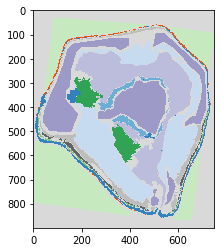

In [34]:
plt.imshow(img_rugo_zones, interpolation='None', cmap='tab20c_r')
plt.show()

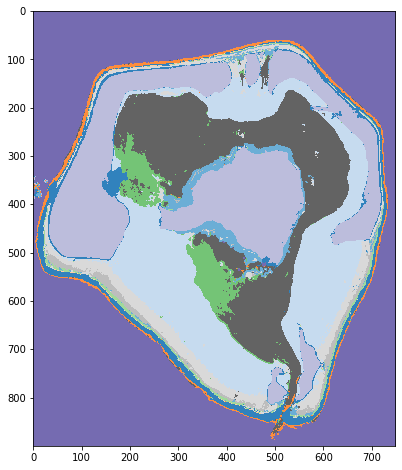

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(predicted_map_pixelbased_rf_classes,  interpolation='None', cmap='tab20c_r')
plt.show()

## Manuel test of segmentations

In [21]:
from skimage.segmentation import felzenszwalb

In [25]:
img_rgb_without_pb = np.dstack([img_blue,img_green,img_red])
img_rgb_with_pb = np.dstack([img_blue, img_green, img_red, predicted_map_pixelbased_rf_classes])

In [27]:
img_rgb_with_pb = np.copy(img_rgb_without_pb)
for i in np.unique(predicted_map_pixelbased_rf_classes):
    temp_array_class = np.zeros(np.shape(predicted_map_pixelbased_rf_classes))
    temp_array_class[predicted_map_pixelbased_rf_classes==i] = 1
    img_rgb_with_pb = np.dstack([img_rgb_with_pb, temp_array_class])

In [28]:
np.shape(img_rgb_with_pb)

(1800, 1500, 15)

In [29]:
segments = felzenszwalb(img_rgb_with_pb, scale=1.5, sigma=1., min_size=50)

<ipython-input-29-06dae735733f>:1: RuntimeWarning: Got image with third dimension of 15. This image will be interpreted as a multichannel 2d image, which may not be intended.
  segments = felzenszwalb(img_rgb_with_pb, scale=1.5, sigma=1., min_size=50)


In [30]:
np.max(segments)

12112

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


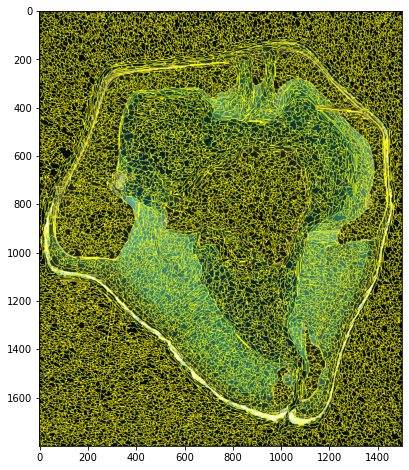

In [40]:
plt.figure(figsize=(8,8))
plt.imshow(mark_boundaries(img,segments))
plt.show()

In [31]:
map_test.segments = segments

## Test of the segmentations

In [48]:
map_test.segmentation(method='fz',scale=1.2, sigma=1.2, min_size=50)

In [29]:
np.max(map_test.segments)

12112

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


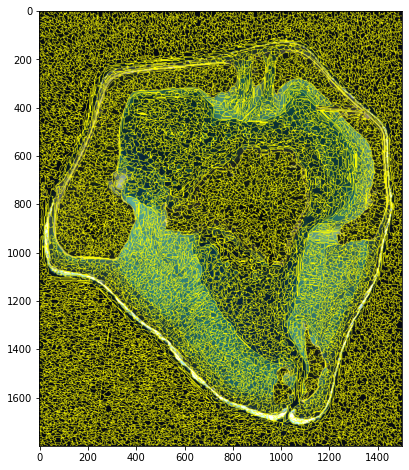

In [165]:
plt.figure(figsize=(8,8))
plt.imshow(mark_boundaries(img,map_test.segments))
plt.show()

In [32]:
map_test.smooth_cnn_rf()

In [33]:
map_test.smoothed_map_cnn_rf = map_test.smoothed_map_cnn_rf+1

In [34]:
# with binary classes (15 channels segmentation)
smooth_pixelbased_rf_score = coral_map_tests.score_map(img_rugo_zones,map_test.smoothed_map_cnn_rf,[0,4,5], map_test.segments, training_set_indexes_pb, [])
smooth_pixelbased_rf_score

0.8745443017910921

In [35]:
# with 4 channels segmentation
smooth_pixelbased_rf_score = coral_map_tests.score_map(img_rugo_zones,map_test.smoothed_map_cnn_rf,[0,4,5], map_test.segments, training_set_indexes_pb, [])
smooth_pixelbased_rf_score

0.8745443017910921

In [36]:
map_smooth_with_pb = map_test.smoothed_map_cnn_rf

In [71]:
map_smooth_without_pb = map_test.smoothed_map_cnn_rf

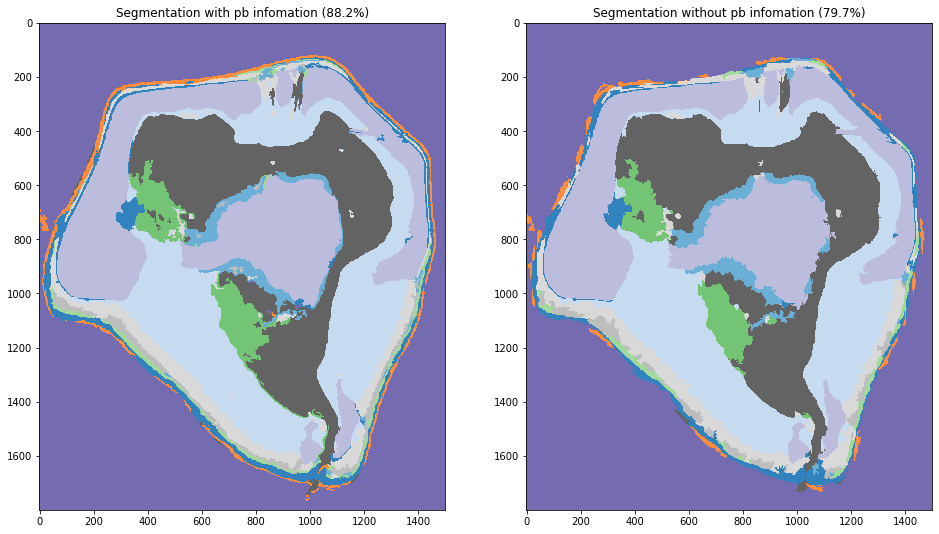

In [73]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(map_smooth_with_pb, interpolation='None', cmap='tab20c_r')
ax[0].set_title('Segmentation with pb infomation (88.2%)')
ax[1].imshow(map_smooth_without_pb, interpolation='None', cmap='tab20c_r')
ax[1].set_title('Segmentation without pb infomation (79.7%)')
#plt.savefig('comparison segmentations with_without pb.png', dpi=200)
plt.show()

In [37]:
labels_segments_ideal = coral_map_tests.create_labels_dataset(map_test.segments,img_rugo_zones)
labels_segments_ideal = np.argmax(labels_segments_ideal, axis=1)

ideal_map_segments = np.copy(img_rugo_zones)
for index_segment in np.unique(map_test.segments):
    ideal_map_segments[map_test.segments==index_segment] = labels_segments_ideal[index_segment]

In [38]:
coral_map_tests.score_map(img_rugo_zones,ideal_map_segments,[0], map_test.segments, [], [])

0.9539219696307224

In [39]:
coral_map_tests.score_map(img_rugo_zones, map_test.smoothed_map_cnn_rf, [0], map_test.segments, [], [])

0.9694733189846066

In [40]:
tab20c_r = cm.get_cmap('tab20c_r',12)
white_col = np.array([1, 1, 1, 1])
newcolors = np.concatenate((np.array([white_col]),tab20c_r(range(12))))
tab20c_r_extended = ListedColormap(newcolors)

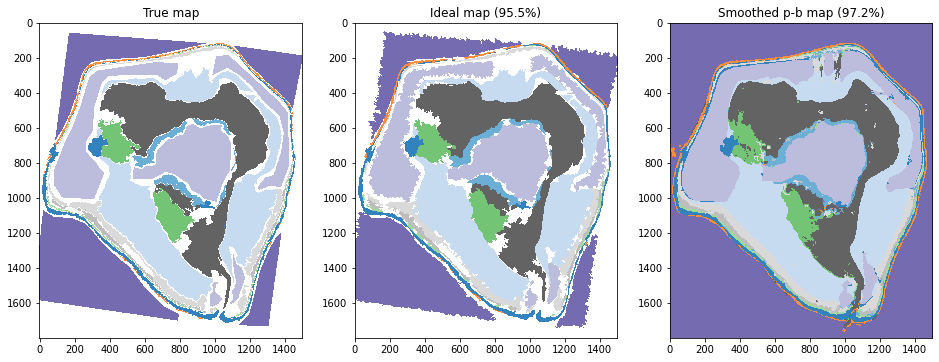

In [137]:
fig,ax = plt.subplots(1,3,figsize=(16,10))
ax[0].imshow(img_rugo_zones, interpolation='None', cmap=tab20c_r_extended)
ax[0].set_title('True map')
ax[1].imshow(ideal_map_segments, interpolation='None', cmap=tab20c_r_extended)
ax[1].set_title('Ideal map (95.5%)')
ax[2].imshow(map_test.smoothed_map_cnn_rf, interpolation='None', cmap=tab20c_r)
ax[2].set_title('Smoothed p-b map (97.2%)')
#plt.savefig('comparison segmentations with_without pb.png', dpi=200)
plt.show()

In [41]:
ideal_score = coral_map_tests.score_map(img_rugo_zones,ideal_map_segments,[0,4,5], map_test.segments, training_set_indexes_pb, [])

In [55]:
print('Ideal score:',ideal_score)
print('Smooth pixelbased RF score:',smooth_pixelbased_rf_score)
print('Scaled:',smooth_pixelbased_rf_score/ideal_score)

Ideal score: 0.8538595656997939
Smooth pixelbased RF score: 0.8840148993501348
Scaled: 1.035316502691665


## Export

In [42]:
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from shapely.geometry import Point

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-42-c54fc2603a60>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using 

In [43]:
filenameraster='../../../Maupiti/Data/New_classification/downsampled_image_pleiades_2.tif'

adr=filenameraster[:-4]

src = rio.open(filenameraster)
X0, Y0, XF, YF=src.bounds
dx=(XF-X0)/src.width
dy=(YF-Y0)/src.height
x=np.arange(X0, XF, dx)
y=np.arange(Y0, YF, dy)

raster_array_original = src.read()

img_final = raster_array_original[:,300:2100,500:2000]

In [104]:
## !!! THIS CELL IS USELESS FOR EXPORT AS SHAPEFILE !!!

with rio.open(filenameraster) as src:
    src_crs = src.crs  # Original CRS
    src_transform = src.transform  # Original transform
    src_bounds = src.bounds  # Original bounds
    
    # Define the target CRS
    target_crs = 'EPSG:32705'

    # Calculate the transform and dimensions of the target CRS
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
    
    # Define the metadata for the target raster
    profile = src.profile
    profile.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create a new raster file with the target CRS
    target_raster = 'reprojected_image.tif'
    with rio.open(target_raster, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )

In [105]:
src = rio.open(target_raster)
X0, Y0, XF, YF=src.bounds
dx=(XF-X0)/src.width
dy=(YF-Y0)/src.height
x=np.arange(X0, XF, dx)
y=np.arange(Y0, YF, dy)

In [44]:
raster_array = src.read()

img_final = raster_array[:,300:2100,500:2000]

In [45]:
row_start = 300
row_end = 2100
col_start = 500
col_end = 2000

x = np.arange(X0 + col_start * dx, X0 + col_end * dx, dx)
y = np.arange(Y0 + row_start * dy, Y0 + row_end * dy, dy)

In [72]:
#map_to_export = 5*np.ones(np.shape(raster_array_original[0]))
map_to_export = 5*np.ones(src.shape)
map_to_export[300:2100,500:2000] = np.flip(map_smooth_with_pb)
#map_to_export[300:2100,500:2000] = np.flip(map_test.predicted_map_round_2)
#map_to_export[300:2100,500:2000] = map_smooth_with_pb

x = np.arange(X0, XF, dx)
y = np.arange(Y0, YF, dy)

In [73]:
x_flat = np.tile(x, len(y))  # Repeat x for each row in y
y_flat = np.repeat(y, len(x))  # Repeat each element in y for every column in x
#img_rugo_flat = predicted_map_pixelbased_rf_classes.flatten()
img_rugo_flat = np.fliplr(np.flip(map_to_export)).flatten()

In [74]:
original_dict = {
    'BackReefSlope': 1, 'InnerReef': 2, 'Lagoon': 3, 'Land': 4,
    'Ocean': 5, 'OuterReefFlat': 6, 'PatchReef': 7, 'ReefCrest': 8,
    'ReefFront': 9, 'ShallowLagoon': 10, 'ShoreReef': 11, 'Unspecified': 12
}
reverse_dict = {v: k for k, v in original_dict.items()}

rugo_flat_strings = np.vectorize(reverse_dict.get)(img_rugo_flat)

In [75]:
# Create a dataframe
data_to_export = pd.DataFrame({'X': x_flat, 'Y': y_flat, 'Value': rugo_flat_strings})

In [76]:
gdf = gpd.GeoDataFrame(data_to_export, geometry=gpd.points_from_xy(data_to_export.X, data_to_export.Y))
#gdf.set_crs(epsg=32705, inplace=True) 
gdf.set_crs(epsg=32731, inplace=True) 

# Save to a shapefile
output_shapefile = 'outputs shp/output_smoothed_pb_5m_with_RGBP.shp'
gdf.to_file(output_shapefile)

# Round 2

In [56]:
# remove the last column in each vector of the segments, because we did not have class 0
map_test.y_segments_cnn_rf = np.delete(map_test.y_segments_cnn_rf, -1, 1)

In [57]:
%%time
map_test.init_regressor_round_2(features_level=4)

Wall time: 52.4 s


In [59]:
np.unique(predicted_map_pixelbased_rf_classes)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [58]:
random.seed(0)
size_train_rf = 4*len(np.unique(map_test.segments))//5
train_indexes_rf = np.random.choice(np.unique(map_test.segments),size=size_train_rf,replace=False)

In [60]:
np.shape(train_indexes_rf)

(9690,)

In [ ]:
%%time
map_test.train_regressor_round_2(train_indexes_rf)

In [61]:
%%time
train_indexes_rf, cond = map_test.train_regressor_round_2(adjust_segments_threshold=0.4, adjust_segments_class=0, random_seed=0)

R2 score (on test set):  0.8857320752334563
Class accuracy (on test set):  0.9899244332493703
Wall time: 41.1 s


In [62]:
train_indexes_rf_real = np.where(cond)[0]
train_indexes_rf_real = train_indexes_rf_real[list(train_indexes_rf)]

In [63]:
%%time
map_test.predict_map_round_2()

Wall time: 939 ms


In [64]:
map_test.predicted_map_round_2 += 1

In [65]:
ideal_score_round_2 = coral_map_tests.score_map(img_rugo_zones,ideal_map_segments,[0,4,5], map_test.segments, training_set_indexes_pb, train_indexes_rf_real)
map_score = coral_map_tests.score_map(map_test.map_img,map_test.predicted_map_round_2,[0,4,5], map_test.segments, training_set_indexes_pb, train_indexes_rf_real)
print('Round 2 score:', map_score)
print('Ideal score:', ideal_score_round_2)
print('Scaled score: ', map_score/ideal_score_round_2)

Round 2 score: 0.76661918328585
Ideal score: 0.5997150997150997
Scaled score:  1.2783056215360253


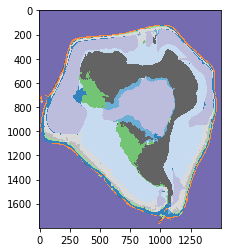

In [66]:
plt.imshow(map_test.predicted_map_round_2, interpolation='None',  cmap='tab20c_r')
plt.show()

In [190]:
map_test.segments in train_indexes_rf

<ipython-input-190-4e533265fe85>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  map_test.segments in train_indexes_rf


False

In [188]:
map_test.segments

array([[    0,     0,     0, ...,   114,   114,   114],
       [    0,     0,     0, ...,   114,   114,   114],
       [    0,     0,     0, ...,   114,   114,   114],
       ...,
       [12178, 12178, 12178, ..., 12082, 12082, 12082],
       [12178, 12178, 12178, ..., 12082, 12082, 12082],
       [12178, 12178, 12178, ..., 12082, 12082, 12082]], dtype=int64)

In [35]:
coral_map_tests.score_map(map_test.map_img,predicted_map_pixelbased_rf_classes,[0,4,5], map_test.segments, training_set_indexes_pb, train_indexes_rf)

0.9003322259136213

In [44]:
%%time
with open("pixelbased_5m_type.pkl", 'wb') as file:
    pickle.dump(map_test.rf_cnn, file)
    
#map_test.load_rf_pixelbased('pixelbased_5m_type.pkl')

Wall time: 31.2 ms


In [43]:
with open("objectbased_5m_type.pkl", 'wb') as file:
    pickle.dump(map_test.rf_reg, file)
    
#map_test.load_regressor_round_2('objectbased_5m_type.pkl')

In [ ]:
predicted_map_pixelbased_rf_classes

### Per-class analysis

In [45]:
list_scores_map = []

for i in np.arange(1,13):
    list_int = list(np.arange(13))
    list_int.remove(i)
    score_map_temp = coral_map_tests.score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,list_int, map_test.segments, training_set_indexes_pb, [])
    list_scores_map.append(score_map_temp)

In [46]:
print(list_scores_map)

[0.8457729041386629, 0.6772207563764292, 0.9649559873775121, 0.9937988676193044, 0.9986626139817629, 0.6891891891891891, 0.6370409792442788, 0.5230769230769231, 0.8098434004474273, 0.9667229949304562, 0.852996254681648, 0.8825278810408922]


In [47]:
list_scores_map_2 = []

for i in np.arange(1,13):
    list_int = list(np.arange(13))
    list_int.remove(i)
    score_map_temp = coral_map_tests.score_map(img_rugo_zones,map_test.smoothed_map_cnn_rf,list_int, map_test.segments, training_set_indexes_pb, [])
    list_scores_map_2.append(score_map_temp)

In [141]:
print(list_scores_map_2)

[0.7856106549052607, 0.5147358759942892, 0.9942330888345559, 0.9956673311305899, 0.9938303584043705, 0.4469972500665306, 0.8243245340410013, 0.0, 0.5425676111792422, 0.9786377296060976, 0.8289991194599354, 0.744353235099169]


In [43]:
from matplotlib.colors import ListedColormap

In [44]:
colors = plt.cm.tab20c_r.colors[:13]  # Using a predefined colormap (tab20) and taking the first 13 colors
custom_cmap = ListedColormap(colors)

In [48]:
classes_type = ['Not classified', 'BackReefSlope', 'InnerReef', 'Lagoon', 'Land', 'Ocean',
       'OuterReefFlat', 'PatchReef', 'ReefCrest', 'ReefFront',
       'ShallowLagoon', 'ShoreReef', 'Unspecified']

list_scores_map_str = [str(np.round(score_class*100,1)) for score_class in list_scores_map]

list_scores_map_str_2 = [str(np.round(score_class*100,1)) for score_class in list_scores_map_2]

In [49]:
classes_type_with_scores = ['Not classified']
for i in range(12):
    classes_type_with_scores.append(classes_type[i+1]+' (pb:'+list_scores_map_str[i]+'%, ob:'+list_scores_map_str_2[i]+'%)')

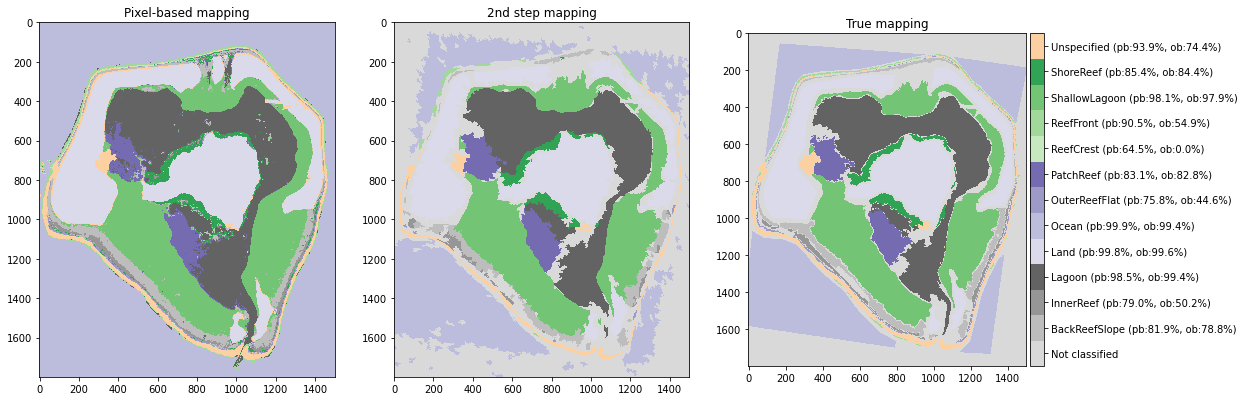

In [105]:
fig,ax = plt.subplots(1,3, figsize=(18,10))

ax[0].imshow(predicted_map_pixelbased_rf_classes,  interpolation='None', cmap=custom_cmap, vmin=0, vmax=12)
ax[0].set_title('Pixel-based mapping')

ax[1].imshow(map_test.predicted_map_round_2, interpolation='None', cmap=custom_cmap, vmin=0, vmax=12)
ax[1].set_title('2nd step mapping')

im = ax[2].imshow(img_rugo_zones, interpolation='None', cmap=custom_cmap, vmin=0, vmax=12)
ax[2].set_title('True mapping')

bounds = np.arange(14)-0.5
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', boundaries=bounds, ticks=np.arange(13))
cbar.ax.set_yticklabels(classes_type_with_scores)

plt.savefig('results_new_classification_5m_bis.png', bbox_inches='tight', dpi=300)

plt.show()

### Export the data as XY file

In [32]:
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from shapely.geometry import Point

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-32-c54fc2603a60>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using 

In [74]:
filenameraster='../../../Maupiti/Data/New_classification/downsampled_image_pleiades_2.tif'

adr=filenameraster[:-4]

src = rio.open(filenameraster)
X0, Y0, XF, YF=src.bounds
dx=(XF-X0)/src.width
dy=(YF-Y0)/src.height
x=np.arange(X0, XF, dx)
y=np.arange(Y0, YF, dy)

raster_array_original = src.read()

img_final = raster_array_original[:,300:2100,500:2000]

In [75]:
src.crs

CRS.from_epsg(32731)

In [68]:
with rio.open(filenameraster) as src:
    src_crs = src.crs  # Original CRS
    src_transform = src.transform  # Original transform
    src_bounds = src.bounds  # Original bounds
    
    # Define the target CRS
    target_crs = 'EPSG:32705'

    # Calculate the transform and dimensions of the target CRS
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds)
    
    # Define the metadata for the target raster
    profile = src.profile
    profile.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create a new raster file with the target CRS
    target_raster = 'reprojected_image.tif'
    with rio.open(target_raster, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )

In [69]:
src = rio.open(target_raster)
X0, Y0, XF, YF=src.bounds
dx=(XF-X0)/src.width
dy=(YF-Y0)/src.height
x=np.arange(X0, XF, dx)
y=np.arange(Y0, YF, dy)

In [38]:
y

array([8174270.99219499, 8174275.99279613, 8174280.99339728, ...,
       8188777.73611791, 8188782.73671905, 8188787.7373202 ])

In [70]:
raster_array = src.read()

img_final = raster_array[:,300:2100,500:2000]

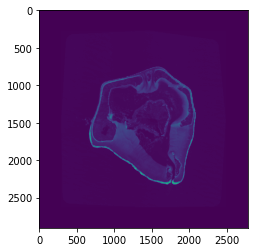

In [71]:
plt.imshow(raster_array[0])

In [40]:
row_start = 300
row_end = 2100
col_start = 500
col_end = 2000

x = np.arange(X0 + col_start * dx, X0 + col_end * dx, dx)
y = np.arange(Y0 + row_start * dy, Y0 + row_end * dy, dy)

In [98]:
map_to_export = 5*np.ones(np.shape(raster_array_original[0]))
#map_to_export[300:2100,500:2000] = np.flip(map_test.smoothed_map_cnn_rf)
map_to_export[300:2100,500:2000] = np.flip(predicted_map_pixelbased_rf_classes)

x = np.arange(X0, XF, dx)
y = np.arange(Y0, YF, dy)

In [99]:
x_flat = np.tile(x, len(y))  # Repeat x for each row in y
y_flat = np.repeat(y, len(x))  # Repeat each element in y for every column in x
#img_rugo_flat = predicted_map_pixelbased_rf_classes.flatten()
img_rugo_flat = np.fliplr(np.flip(map_to_export)).flatten()

In [100]:
original_dict = {
    'BackReefSlope': 1, 'InnerReef': 2, 'Lagoon': 3, 'Land': 4,
    'Ocean': 5, 'OuterReefFlat': 6, 'PatchReef': 7, 'ReefCrest': 8,
    'ReefFront': 9, 'ShallowLagoon': 10, 'ShoreReef': 11, 'Unspecified': 12
}
reverse_dict = {v: k for k, v in original_dict.items()}

rugo_flat_strings = np.vectorize(reverse_dict.get)(img_rugo_flat)

In [101]:
# Create a dataframe
data_to_export = pd.DataFrame({'X': x_flat, 'Y': y_flat, 'Value': rugo_flat_strings})

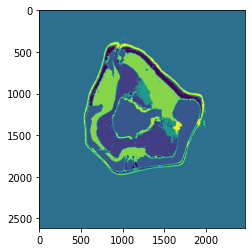

In [102]:
plt.imshow(map_to_export)

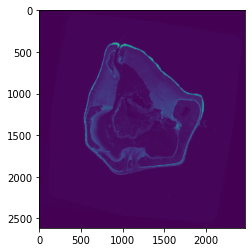

In [64]:
plt.imshow(raster_array_original[0])
plt.show()

In [103]:
gdf = gpd.GeoDataFrame(data_to_export, geometry=gpd.points_from_xy(data_to_export.X, data_to_export.Y))
#gdf.set_crs(epsg=32705, inplace=True) 
gdf.set_crs(epsg=32731, inplace=True) 

# Save to a shapefile
output_shapefile = 'outputs shp/output_pb_5m.shp'
gdf.to_file(output_shapefile)

In [48]:
data_to_export.to_csv('objectbased_classification.csv')

In [89]:
np.unique(img_rugo_flat)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 10., 11., 12.])

# Testing with training set in % size

In [45]:
random.seed(0)
size_subset = len(classified_pixels[0])//4
#size_subset = 212695
index_combination = list(np.array(classified_pixels).T)
random_train_test = random.sample(index_combination,size_subset)
training_set_indexes_pb = random_train_test[:size_subset//5]
testing_set_indexes_pb = random_train_test[size_subset//5:]

In [47]:
%%time
map_test.train_pixelbased_rf(training_set_indexes_pb,testing_set_indexes_pb, undersampling=0)

..\coral_map_tests.py:234: UserWarning: The training set does not contain all the classes. Errors may occur.
  warnings.warn("The training set does not contain all the classes. Errors may occur.")


Creating the labels for each superpixel...
Creating the features for each superpixel...
Training the Random Forest classifier...
Validation accuracy: 0.984672472147793
Wall time: 8min 44s


In [48]:
%%time
map_test.predict_map_pixelbased_rf()

Wall time: 1min 11s


In [49]:
predicted_map_pixelbased_rf_classes = np.argmax(map_test.predicted_map_cnn_rf,axis=2)+1
coral_map_tests.score_map(img_rugo_zones,predicted_map_pixelbased_rf_classes,[0,3,4], map_test.segments, training_set_indexes_pb, [])

0.9716195958291873

In [50]:
map_test.smooth_cnn_rf()

map_test.smoothed_map_cnn_rf = map_test.smoothed_map_cnn_rf+1

smooth_pixelbased_rf_score = coral_map_tests.score_map(img_rugo_zones,map_test.smoothed_map_cnn_rf,[0,3,4], map_test.segments, training_set_indexes_pb, [])
smooth_pixelbased_rf_score

0.9437277915877595

In [51]:
labels_segments_ideal = coral_map_tests.create_labels_dataset(map_test.segments,img_rugo_zones)
labels_segments_ideal = np.argmax(labels_segments_ideal, axis=1)

ideal_map_segments = np.copy(img_rugo_zones)
for index_segment in np.unique(map_test.segments):
    ideal_map_segments[map_test.segments==index_segment] = labels_segments_ideal[index_segment]

In [52]:
ideal_score = coral_map_tests.score_map(img_rugo_zones,ideal_map_segments,[0,3,4], map_test.segments, training_set_indexes_pb, [])

In [53]:
print('Ideal score:',ideal_score)
print('Smooth pixelbased RF score:',smooth_pixelbased_rf_score)
print('Scaled:',smooth_pixelbased_rf_score/ideal_score)

Ideal score: 0.9069353847397522
Smooth pixelbased RF score: 0.9437277915877595
Scaled: 1.0405678369893627


### Round 2

In [54]:
%%time
map_test.init_regressor_round_2(features_level=4)

Wall time: 2.24 s


In [55]:
random.seed(0)
size_train_rf = 4*len(np.unique(map_test.segments))//5
train_indexes_rf = np.random.choice(np.unique(map_test.segments),size=size_train_rf,replace=False)

In [56]:
map_test.train_regressor_round_2(train_indexes_rf)

R2 score (on test set):  0.7496821048676052
Class accuracy (on test set):  0.8422535211267606


In [57]:
%%time
map_test.predict_map_round_2()

Wall time: 296 ms


In [58]:
ideal_score_round_2 = coral_map_tests.score_map(img_rugo_zones,ideal_map_segments,[0,3,4], map_test.segments, training_set_indexes_pb, train_indexes_rf)
map_score = coral_map_tests.score_map(map_test.map_img,map_test.predicted_map_round_2,[0,3,4], map_test.segments, training_set_indexes_pb, train_indexes_rf)
print('Round 2 score:', map_score)
print('Ideal score:', ideal_score_round_2)
print('Scaled score: ', map_score/ideal_score_round_2)

Round 2 score: 0.8418528014046784
Ideal score: 0.9044080692669334
Scaled score:  0.9308329171444047


In [59]:
coral_map_tests.score_map(map_test.map_img,predicted_map_pixelbased_rf_classes,[0,3,4], map_test.segments, training_set_indexes_pb, train_indexes_rf)

0.9705259273867765